In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
torch.__version__

'1.9.0'

### 数据集介绍
MNIST包含6万张28 * 28的训练样本，1万张测试样本；

这里从头搭建一个卷积神经网络，使识别准确率高达99%

In [126]:
# 
BATCH_SIZE = 512 
# 训练批次
EPOCHS = 20

pytorch环境中包含MNIST的数据集，直接使用即可。第一次执行会生成data_mnist文件夹，需要一些时间下载，如果下载过了，就不需要再次下载了。

In [67]:
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data_mnist', train=True, download=True, 
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=BATCH_SIZE, shuffle=True)

tensor(7) tensor(4) tensor(9) tensor(2)


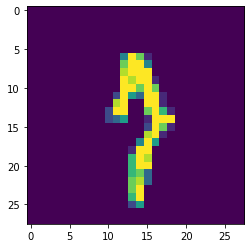

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# 展示图像
def imshow(img):
#     img = img * 0.3081 + 0.1307     # unnormalize
#     print(img)
    npimg = img.numpy()
    plt.imshow(npimg)


# 获取随机数据
dataiter = iter(train_loader)
images, labels = dataiter.next()

# 展示图像
imshow(images[0][0])
# 显示图像标签
print(' '.join('%5s' % labels[j] for j in range(4)))
# images[0][0].shape

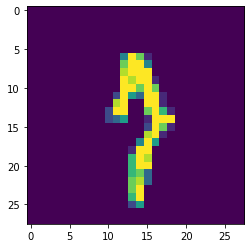

In [62]:
img = images * 0.3081 + 0.1307 
img[0][0]
plt.imshow(img[0][0].numpy())
# img[0][0].numpy()

In [44]:
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data_mnist', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=BATCH_SIZE, shuffle=True)

C:\Users\admin\anaconda3\envs\pytorch\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [45]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.shape

torch.Size([512, 1, 28, 28])

定义一个网络，包含两个卷积层，conv1和cinv2，紧接着两个线性层作为输出，最后输出10个维度作为0-9的标识来确定识别出的是哪个数字。

In [11]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        # 输入数据为batch*1*28*28 黑白图像 分辨率为28*28
        # nn.Conv2d三个参数分别指 输入通道数 输出通道数 卷积核大小
        self.conv1 = nn.Conv2d(1, 10, 5)
        self.conv2 = nn.Conv2d(10, 20, 3)
        # 全连接层Linear的两个参数分别指 输入通道数 输出通道数
        self.fc1 = nn.Linear(20*10*10, 500)
        self.fc2 = nn.Linear(500, 10)
    def forward(self, x):
        in_size = x.size(0) # 即为batch_size的值 512
        out = self.conv1(x) # 512*1*28*28 -> 512*10*24*24
        out = F.relu(out) # 激活函数后 维度不变
        out = F.max_pool2d(out, 2, 2) # 2*2的池化层后，维度减半
        # 512*10*24*24 -> 512*10*12*12
        out = self.conv2(out) # 512*10*12*12 -> 512*20*10*10
        out = F.relu(out)
        out = out.view(in_size, -1) # 512*20*10*10 -> 512*2000
        out = self.fc1(out) # 512*2000 -> 512*500
        out = F.relu(out)
        out = self.fc2(out) # 512*500 -> 512*10
        out = F.log_softmax(out, dim=1) # 计算log(softmax(x)) 转化为0-1之间
        return out

实例化一个网络

优化器选择简单的adam

In [127]:
model = ConvNet()
optimizer = optim.Adam(model.parameters())

定义一个训练的函数

In [123]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
#         data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if(batch_idx+1)%30 == 0: 
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

定义一个测试的函数

In [114]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.max(1, keepdim=True)[1] # 找到概率最大的下标
            correct += pred.eq(target.view_as(pred)).sum().item()
            test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [69]:
# 识别准确率达到99%
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Train Epoch: 1 [14848/60000 (25%)]	Loss: 0.073277
Train Epoch: 1 [30208/60000 (50%)]	Loss: 0.109212
Train Epoch: 1 [45568/60000 (75%)]	Loss: 0.079269

Test set: Average loss: 0.0022, Accuracy: 9819/10000 (98%)

Train Epoch: 2 [14848/60000 (25%)]	Loss: 0.054845
Train Epoch: 2 [30208/60000 (50%)]	Loss: 0.067020
Train Epoch: 2 [45568/60000 (75%)]	Loss: 0.074126

Test set: Average loss: 0.0008, Accuracy: 9856/10000 (99%)

Train Epoch: 3 [14848/60000 (25%)]	Loss: 0.043873
Train Epoch: 3 [30208/60000 (50%)]	Loss: 0.039775
Train Epoch: 3 [45568/60000 (75%)]	Loss: 0.032151

Test set: Average loss: 0.0006, Accuracy: 9886/10000 (99%)

Train Epoch: 4 [14848/60000 (25%)]	Loss: 0.035329
Train Epoch: 4 [30208/60000 (50%)]	Loss: 0.041777
Train Epoch: 4 [45568/60000 (75%)]	Loss: 0.029396

Test set: Average loss: 0.0013, Accuracy: 9889/10000 (99%)

Train Epoch: 5 [14848/60000 (25%)]	Loss: 0.014097
Train Epoch: 5 [30208/60000 (50%)]	Loss: 0.032836
Train Epoch: 5 [45568/60000 (75%)]	Loss: 0.039692

Test 

### !!!专用于kaggle 手写数字识别

https://www.kaggle.com/c/digit-recognizer/leaderboard

In [1]:
import pandas as pd
import numpy as np

In [3]:
train = pd.read_csv('digit-recognizer/train.csv')
test = pd.read_csv('digit-recognizer/test.csv')

In [4]:
test.shape[0]

28000

In [5]:
train_data = train.iloc[:,1:].values.astype('float32')
train_data = train_data.reshape((42000, 1, 28, 28))
train_label = train.iloc[:,0].values
test_data = test.values.astype('float32')
test_data = test_data.reshape((28000, 1, 28, 28))

In [15]:
train_data.shape

(42000, 1, 28, 28)

In [21]:
train_label[range(512, 512*2)].shape

(512,)

In [128]:
def train_kaggle(model, train_data, train_label, optimizer, epoch):
    model.train()
    batch_idx = 0
    for batch_idx in range(int(train_data.shape[0] / 512) + 1):
        rng = range(512 * batch_idx, min(512 * (1 + batch_idx), train_data.shape[0]))
        data = torch.from_numpy(train_data[rng,:])
        target = torch.from_numpy(train_label[rng])
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if(batch_idx+1)%30 == 0: 
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * 512, train_data.shape[0],
                100. * batch_idx * 512 / train_data.shape[0], loss.item()))

In [129]:
for epoch in range(1, EPOCHS + 1):
    train_kaggle(model, train_data, train_label, optimizer, epoch)

Train Epoch: 1 [14848/42000 (35%)]	Loss: 0.448159
Train Epoch: 1 [30208/42000 (72%)]	Loss: 0.151251
Train Epoch: 2 [14848/42000 (35%)]	Loss: 0.075001
Train Epoch: 2 [30208/42000 (72%)]	Loss: 0.054508
Train Epoch: 3 [14848/42000 (35%)]	Loss: 0.042718
Train Epoch: 3 [30208/42000 (72%)]	Loss: 0.027804
Train Epoch: 4 [14848/42000 (35%)]	Loss: 0.018764
Train Epoch: 4 [30208/42000 (72%)]	Loss: 0.012655
Train Epoch: 5 [14848/42000 (35%)]	Loss: 0.014359
Train Epoch: 5 [30208/42000 (72%)]	Loss: 0.010205
Train Epoch: 6 [14848/42000 (35%)]	Loss: 0.006431
Train Epoch: 6 [30208/42000 (72%)]	Loss: 0.004252
Train Epoch: 7 [14848/42000 (35%)]	Loss: 0.011322
Train Epoch: 7 [30208/42000 (72%)]	Loss: 0.009135
Train Epoch: 8 [14848/42000 (35%)]	Loss: 0.001984
Train Epoch: 8 [30208/42000 (72%)]	Loss: 0.002506
Train Epoch: 9 [14848/42000 (35%)]	Loss: 0.008253
Train Epoch: 9 [30208/42000 (72%)]	Loss: 0.001359
Train Epoch: 10 [14848/42000 (35%)]	Loss: 0.000761
Train Epoch: 10 [30208/42000 (72%)]	Loss: 0.00115

In [131]:
def test_kaggle(model, test_data):
    model.eval()
    test_loss = 0
    correct = 0
    ans = []
    with torch.no_grad():
        for batch_idx in range(int(test_data.shape[0] / 512) + 1):
            rng = range(512 * batch_idx, min(512 * (1 + batch_idx), test_data.shape[0]))
            data = torch.from_numpy(test_data[rng,:])
            output = model(data)
            pred = output.max(1, keepdim=True)[1] # 找到概率最大的下标
            pred = pred.numpy()
            ans.append(pred.reshape((1, pred.shape[0])))
    print('完成！')
    return ans
    

In [46]:
test_data[range(512),:].shape

(512, 1, 28, 28)

In [132]:
result = test_kaggle(model, test_data)

完成！


In [133]:
ans = []
for res in result:
    for aa in res:
        for a in aa:
            ans.append(a)

In [108]:
len(ans)

28000

In [134]:
commit = pd.read_csv('digit-recognizer/sample_submission.csv')
commit['Label'] = ans

In [135]:
commit.to_csv('digit-recognizer/commit.csv', index=False)